GPU non disponible, l'entraînement sera fait sur le CPU
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


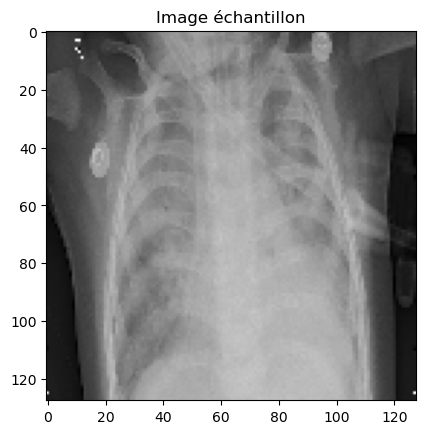

Training fold 1...
Epoch 1/7


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 897s 11s/step - AUC: 0.5203 - accuracy: 0.6840 - loss: 0.6594 - val_AUC: 0.7500 - val_accuracy: 0.6250 - val_loss: 1.3699
Epoch 2/7
75/82 ━━━━━━━━━━━━━━━━━━━━ 1:13 10s/step - AUC: 0.9463 - accuracy: 0.8938 - loss: 0.2553

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Hyperparamètres
img_size = (128, 128)
batch_size = 64
epochs = 7
data_dir_train = "../../../chest_xray/train/"
data_dir_test = "../../../chest_xray/test/"
data_dir_val = "../../../chest_xray/val/"

# Vérification de la disponibilité du GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU disponible")
else:
    print("GPU non disponible, l'entraînement sera fait sur le CPU")

# Prétraitement des données
def preprocess_data(data_dir_train, data_dir_val, data_dir_test, img_size, batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    train_generator = datagen.flow_from_directory(
        data_dir_train,
        target_size=img_size,
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="binary"
    )
    
    val_generator = datagen.flow_from_directory(
        data_dir_val,
        target_size=img_size,
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="binary"
    )
    
    test_generator = datagen.flow_from_directory(
        data_dir_test,
        target_size=img_size,
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="binary"
    )
    
    return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = preprocess_data(data_dir_train, data_dir_val, data_dir_test, img_size, batch_size)

# Visualisation d'une image pour vérifier le prétraitement
def plot_sample_image(generator):
    sample_image, _ = next(generator)
    plt.imshow(sample_image[0].reshape(128, 128), cmap='gray')
    plt.title("Image échantillon")
    plt.show()

plot_sample_image(train_generator)

# Création du modèle CNN
def create_model():
    model = models.Sequential([
        layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(1024, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])
    
    return model

# Entraînement du modèle avec validation croisée K-Fold
def train_model(train_generator, val_generator, epochs, early_stop):
    histories = []
    models_list = []

    for fold in range(2):  # Teste K-Fold ici, changez à k=nombre de folds
        print(f"Training fold {fold+1}...")
        
        # Création d'un modèle pour chaque fold
        model = create_model()
        
        # Entraînement du modèle
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            verbose=1,
            callbacks=[early_stop]
        )
        
        histories.append(history.history)
        models_list.append(model)
    
    return models_list, histories

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
models_list, histories = train_model(train_generator, val_generator, epochs, early_stop)

# Sélection du modèle final (peut-être le premier ou le meilleur selon la validation)
model_final = models_list[0]

# Évaluation du modèle final sur l'ensemble de test
def evaluate_model(model_final, test_generator):
    test_loss, test_acc, test_auc = model_final.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc}")
    print(f"Test AUC: {test_auc}")

evaluate_model(model_final, test_generator)

# Prédiction sur les données de test
def predict_test(model_final, test_generator):
    test_image, _ = next(test_generator)
    pred = model_final.predict(test_image)
    print(f"Predicted class: {'PNEUMONIA' if pred[0][0] > 0.5 else 'NORMAL'}")
    
predict_test(model_final, test_generator)

# Visualisation des courbes d'apprentissage
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    
    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_learning_curves(histories[0])

# Prédictions
def display_predictions(model, test_gen):
    test_images, _ = next(test_gen)
    predictions = model.predict(test_images)
    predicted_classes = (predictions > 0.5).astype(int)
    
    for i in range(len(test_images)):
        plt.imshow(test_images[i].squeeze(), cmap='gray')
        plt.title(f'Prédiction : {"Pneumonie" if predicted_classes[i] == 1 else "Normal"}')
        plt.show()

# Choisissez un modèle pour afficher les prédictions
# Vous devez d'abord entraîner un modèle et l'enregistrer pour cette partie du code
# Assurez-vous que le fichier du modèle existe avant de le charger
# Remplacez 'model_final.h5' par le nom réel du fichier du modèle enregistré
# model_to_use = tf.keras.models.load_model('model_final.h5')
# display_predictions(model_to_use, test_generator)